In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

In [2]:
# Définir les chemins des fichiers
file_path = "IHME-GBD_2021_DATA-db2c71f9-1.csv"

df = pd.read_csv(file_path)

print(df.head)

<bound method NDFrame.head of           measure location     sex          age  \
0          Deaths    Italy    Male  15-49 years   
1          Deaths    Italy  Female  15-49 years   
2          Deaths    Italy    Male  15-49 years   
3          Deaths    Italy  Female  15-49 years   
4          Deaths    Italy    Male  15-49 years   
...           ...      ...     ...          ...   
385555  Incidence    Sudan  Female    75+ years   
385556  Incidence    Sudan    Male    75+ years   
385557  Incidence    Sudan  Female    75+ years   
385558  Incidence    Sudan    Male    75+ years   
385559  Incidence    Sudan  Female    75+ years   

                                                    cause   metric  year  \
0                   Chronic obstructive pulmonary disease   Number  2017   
1                   Chronic obstructive pulmonary disease   Number  2017   
2                   Chronic obstructive pulmonary disease  Percent  2017   
3                   Chronic obstructive pulmonary dis

In [3]:
# Aperçu rapide
print(df.shape)
print(df.info())
print(df.head())

# Statistiques de base
print(df.describe(include='all'))

# Valeurs uniques par colonne
for col in df.columns:
    print(f"{col}: {df[col].nunique()} valeurs uniques")


(385560, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 385560 entries, 0 to 385559
Data columns (total 10 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   measure   385560 non-null  object 
 1   location  385560 non-null  object 
 2   sex       385560 non-null  object 
 3   age       385560 non-null  object 
 4   cause     385560 non-null  object 
 5   metric    385560 non-null  object 
 6   year      385560 non-null  int64  
 7   val       385560 non-null  float64
 8   upper     385560 non-null  float64
 9   lower     385560 non-null  float64
dtypes: float64(3), int64(1), object(6)
memory usage: 29.4+ MB
None
  measure location     sex          age  \
0  Deaths    Italy    Male  15-49 years   
1  Deaths    Italy  Female  15-49 years   
2  Deaths    Italy    Male  15-49 years   
3  Deaths    Italy  Female  15-49 years   
4  Deaths    Italy    Male  15-49 years   

                                   cause   metric  year        val   

In [6]:
# Vérifier les valeurs manquantes
print(df.isnull().sum())

# Supprimer les lignes ou colonnes vides si nécessaire
df_clean = df.dropna()

# Harmoniser les noms de colonnes
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# Vérifier les doublons
print(df.duplicated().sum())
df = df.drop_duplicates()

measure     0
location    0
sex         0
age         0
cause       0
metric      0
year        0
val         0
upper       0
lower       0
dtype: int64
0


In [7]:
# Distribution des catégories
for col in ['measure', 'location', 'sex', 'age', 'cause', 'metric']:
    print(f"\n--- {col} ---")
    print(df[col].value_counts())



--- measure ---
measure
DALYs (Disability-Adjusted Life Years)    97920
Prevalence                                97920
Incidence                                 97920
Deaths                                    91800
Name: count, dtype: int64

--- location ---
location
Afghanistan                 1890
Paraguay                    1890
Niue                        1890
North Macedonia             1890
Northern Mariana Islands    1890
                            ... 
Greece                      1890
Greenland                   1890
Grenada                     1890
Guam                        1890
Zimbabwe                    1890
Name: count, Length: 204, dtype: int64

--- sex ---
sex
Female    192780
Male      192780
Name: count, dtype: int64

--- age ---
age
15-49 years    97920
50-74 years    97920
75+ years      97920
0-14 years     91800
Name: count, dtype: int64

--- cause ---
cause
Asthma                                                 97920
Interstitial lung disease and pulmonary sa

In [ ]:
# --- Étape 1 : Sélectionner la cible (Y) ---


CAUSE_A_MODELISER = 'Asthma' 
MESURE_A_MODELISER = 'Incidence'
METRIQUE_A_MODELISER = 'Rate'


print(f"Filtre appliqué : Cause='{CAUSE_A_MODELISER}', Measure='{MESURE_A_MODELISER}', Metric='{METRIQUE_A_MODELISER}'")

data_model = df[
    (df['cause'] == CAUSE_A_MODELISER) &
    (df['measure'] == MESURE_A_MODELISER) &
    (df['metric'] == METRIQUE_A_MODELISER)
].copy()

# 'val' est notre cible Y
Y = data_model['val']

print(f"Nombre d'échantillons pour la modélisation : {len(Y)}")

# --- Étape 2 : Sélectionner les features (X) ---
features = ['location', 'sex', 'age', 'year']
X = data_model[features]

print(f"Features (X) utilisées : {features}")

# --- Étape 3 : Définir le pipeline de transformation ---
categorical_features = ['location', 'sex', 'age']
numeric_features = ['year']

# Pipeline pour les colonnes catégorielles
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore')) 
])

# Pipeline pour les colonnes numériques
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

# Préprocesseur complet
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# --- Étape 4 : Diviser les données en ensembles d'entraînement et de test ---
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print(f"Taille Train set: {X_train.shape[0]} échantillons")
print(f"Taille Test set: {X_test.shape[0]} échantillons")

Filtre appliqué : Cause='Asthma', Measure='Incidence', Metric='Rate'
Nombre d'échantillons pour la modélisation : 8160
Features (X) utilisées : ['location', 'sex', 'age', 'year']
Taille Train set: 6528 échantillons
Taille Test set: 1632 échantillons


Données pour la métrique 'Rate' : 128520 lignes
Affichage du Graphique 1 : Distribution par Cause


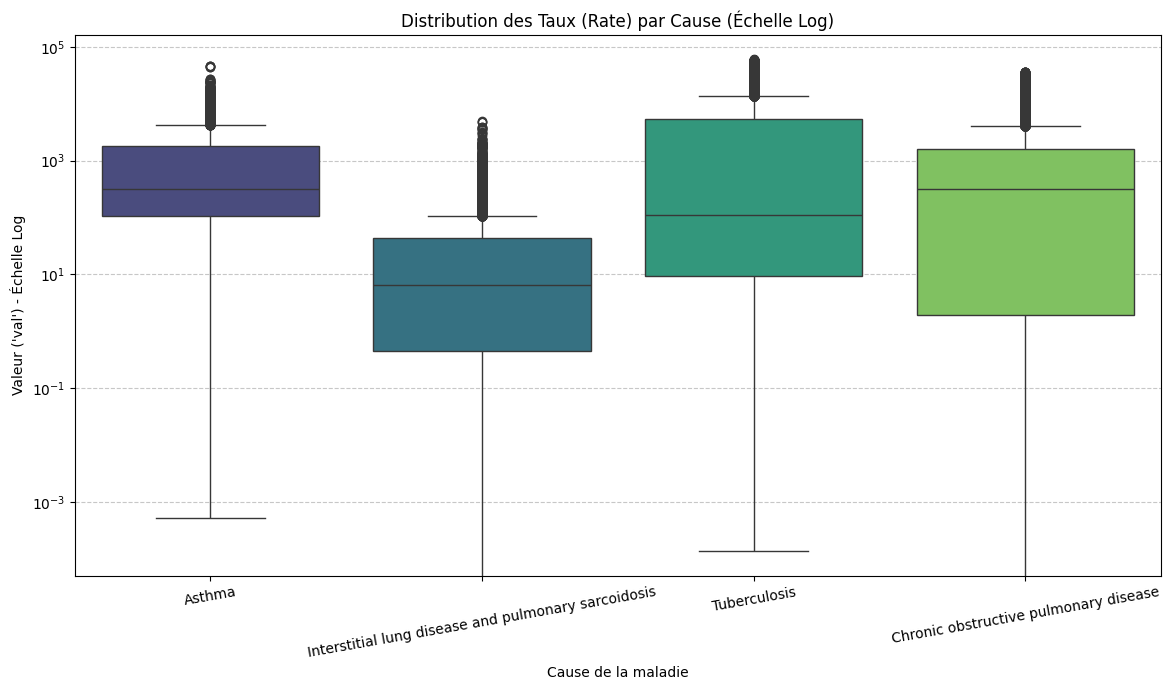


Affichage du Graphique 2 : Tendance Temporelle par Cause


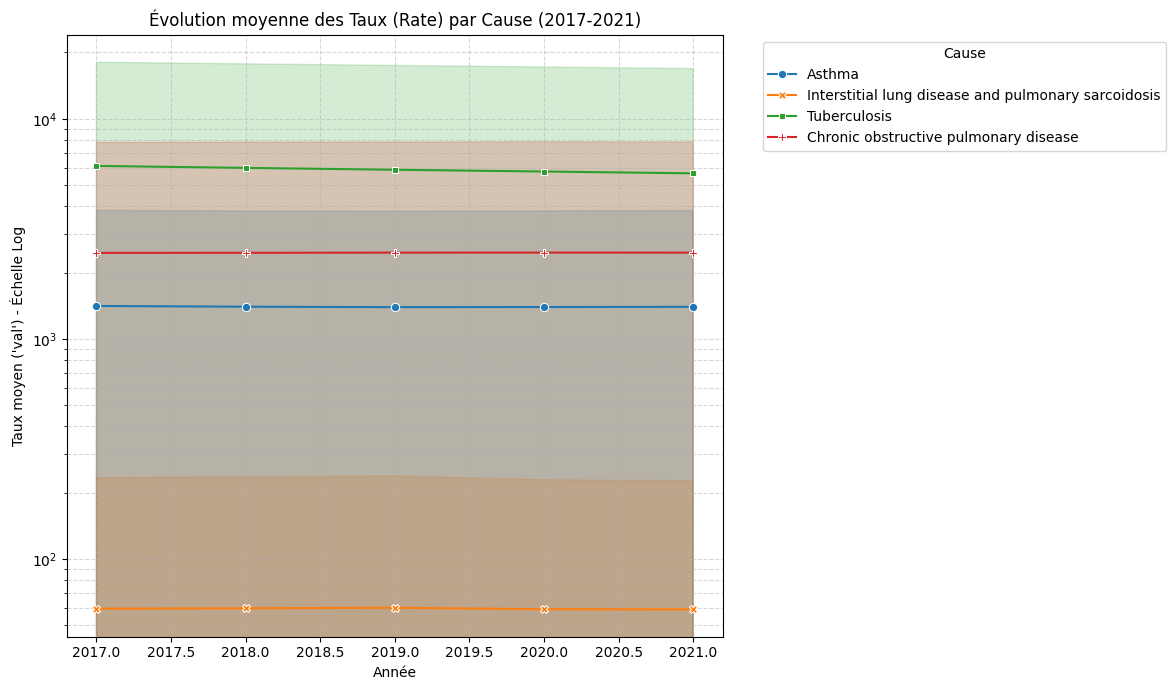


Affichage du Graphique 3 : Focus Asthme par Âge


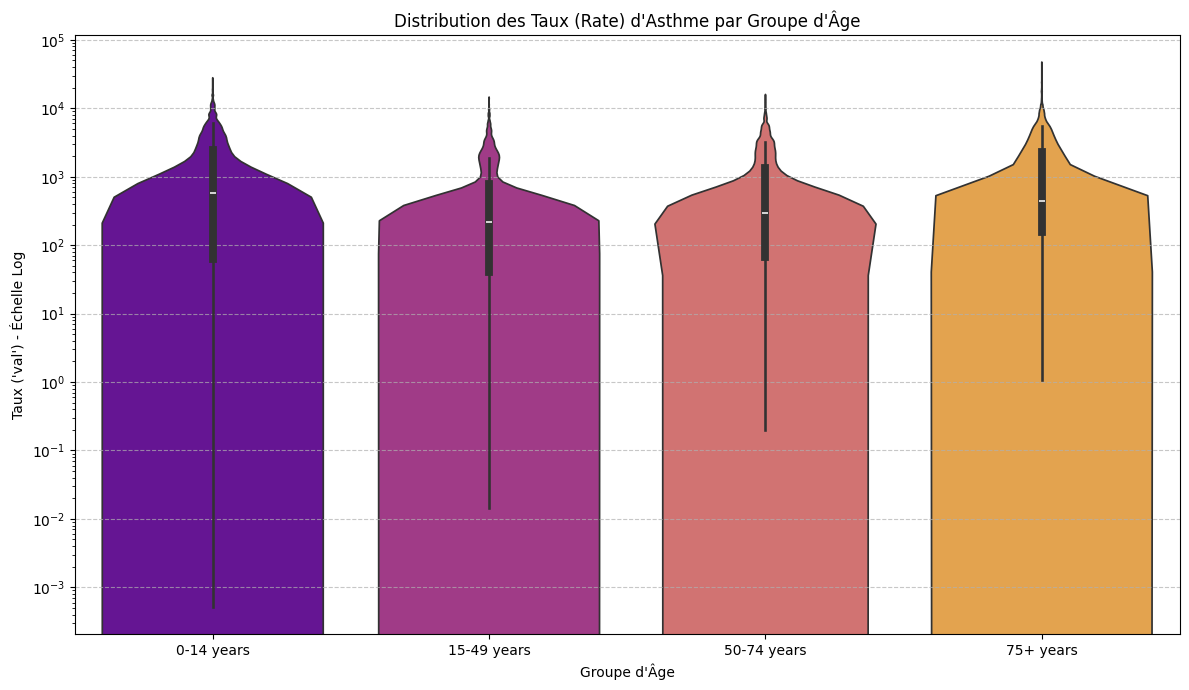

In [39]:
# --- Préparation : Filtrer sur la métrique 'Rate' ---
# Nous créons un nouveau DataFrame ne contenant que les lignes 'Rate'
df_rate = df[df['metric'] == 'Rate'].copy()
print(f"Données pour la métrique 'Rate' : {df_rate.shape[0]} lignes")


# --- Visualisation 1 : Distribution des Taux par Cause ---
print("Affichage du Graphique 1 : Distribution par Cause")
plt.figure(figsize=(12, 7))
sns.boxplot(data=df_rate, x='cause', y='val', hue='cause', palette='viridis', legend=False)
plt.yscale('log') # Échelle log pour une meilleure lisibilité
plt.title("Distribution des Taux (Rate) par Cause (Échelle Log)")
plt.ylabel("Valeur ('val') - Échelle Log")
plt.xlabel("Cause de la maladie")
plt.xticks(rotation=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show() # Affiche le graphique


# --- Visualisation 2 : Tendance des Taux dans le temps par Cause ---
print("\nAffichage du Graphique 2 : Tendance Temporelle par Cause")
plt.figure(figsize=(12, 7))
sns.lineplot(data=df_rate, x='year', y='val', hue='cause', style='cause', markers=True, dashes=False, errorbar='sd')
plt.yscale('log') # Échelle log ici aussi
plt.title("Évolution moyenne des Taux (Rate) par Cause (2017-2021)")
plt.ylabel("Taux moyen ('val') - Échelle Log")
plt.xlabel("Année")
plt.legend(title='Cause', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.tight_layout()
plt.show() # Affiche le graphique


# --- Visualisation 3 : Distribution des Taux par Groupe d'Âge (pour l'Asthme) ---
print("\nAffichage du Graphique 3 : Focus Asthme par Âge")
# Se concentrer sur une seule cause, par exemple 'Asthma'
df_rate_asthma = df_rate[df_rate['cause'] == 'Asthma']

# Récupérer l'ordre correct des âges (il peut y avoir 'All Ages')
age_order = sorted(df_rate_asthma['age'].unique())

plt.figure(figsize=(12, 7))
sns.violinplot(data=df_rate_asthma, x='age', y='val', hue='age', palette='plasma', 
               legend=False, order=age_order)
plt.yscale('log')
plt.title("Distribution des Taux (Rate) d'Asthme par Groupe d'Âge")
plt.ylabel("Taux ('val') - Échelle Log")
plt.xlabel("Groupe d'Âge")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show() # Affiche le graphique


--- Modèle 1 : Régression Linéaire ---
Performance (Test Set) :
R² (Score) : 0.6601
RMSE : 360.4632


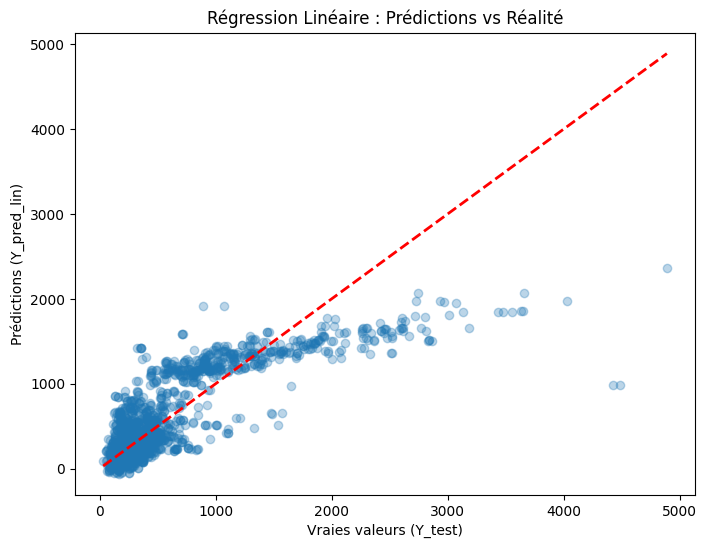

In [29]:
print("\n--- Modèle 1 : Régression Linéaire ---")

# 1. Prétraitement, 2. Modèle
pipeline_lin_reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Entraîner le modèle
pipeline_lin_reg.fit(X_train, Y_train)

# Prédire sur l'ensemble de test
Y_pred_lin = pipeline_lin_reg.predict(X_test)

# Évaluer les performances
rmse_lin = np.sqrt(mean_squared_error(Y_test, Y_pred_lin))
r2_lin = r2_score(Y_test, Y_pred_lin)

print(f"Performance (Test Set) :")
print(f"R² (Score) : {r2_lin:.4f}")
print(f"RMSE : {rmse_lin:.4f}")

# Visualisation rapide des prédictions vs réalité
plt.figure(figsize=(8, 6))
plt.scatter(Y_test, Y_pred_lin, alpha=0.3)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], '--', color='red', lw=2)
plt.xlabel("Vraies valeurs (Y_test)")
plt.ylabel("Prédictions (Y_pred_lin)")
plt.title("Régression Linéaire : Prédictions vs Réalité")
plt.show()


--- Modèle 2 : Random Forest Regressor ---
Performance (Test Set) :
R² (Score) : 0.9931
RMSE : 51.2564


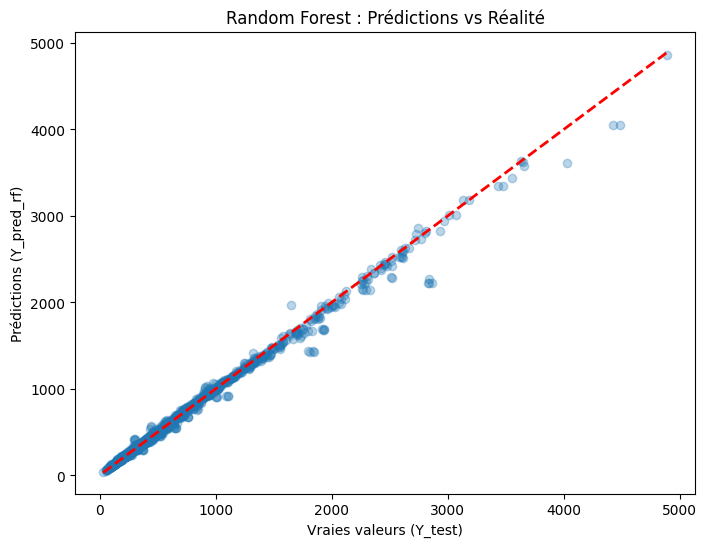

In [30]:
print("\n--- Modèle 2 : Random Forest Regressor ---")

# Créer le pipeline complet
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))
])

# Entraîner le modèle
pipeline_rf.fit(X_train, Y_train)

# Prédire sur l'ensemble de test
Y_pred_rf = pipeline_rf.predict(X_test)

# Évaluer les performances
rmse_rf = np.sqrt(mean_squared_error(Y_test, Y_pred_rf))
r2_rf = r2_score(Y_test, Y_pred_rf)

print(f"Performance (Test Set) :")
print(f"R² (Score) : {r2_rf:.4f}")
print(f"RMSE : {rmse_rf:.4f}")

# Visualisation rapide des prédictions vs réalité
plt.figure(figsize=(8, 6))
plt.scatter(Y_test, Y_pred_rf, alpha=0.3)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], '--', color='red', lw=2)
plt.xlabel("Vraies valeurs (Y_test)")
plt.ylabel("Prédictions (Y_pred_rf)")
plt.title("Random Forest : Prédictions vs Réalité")
plt.show()

In [33]:
# --- Étape 1 : Définir la grille de paramètres à tester ---

# IMPORTANT : Puisque le modèle est dans un pipeline à l'étape 'regressor',
# nous devons préfixer chaque paramètre par 'regressor__'

param_dist = {
    # Nombre d'arbres dans la forêt
    'regressor__n_estimators': [100, 200, 300, 500],
    
    # Nombre de features à considérer à chaque split
    'regressor__max_features': ['sqrt', 'log2', 1.0],
    
    # Profondeur maximale de l'arbre
    'regressor__max_depth': [10, 20, 30, None], # None = pas de limite
    
    # Nombre minimum d'échantillons requis pour diviser un nœud
    'regressor__min_samples_split': [2, 5, 10],
    
    # Nombre minimum d'échantillons requis à chaque nœud feuille
    'regressor__min_samples_leaf': [1, 2, 4]
}

print("--- Début du fine-tuning (RandomizedSearchCV) pour Random Forest ---")

# --- Étape 2 : Initialiser la recherche aléatoire ---

# pipeline_rf est votre pipeline défini au Modèle 2
# n_iter=10 : Testera 10 combinaisons aléatoires (rapide)
#             Augmentez pour une recherche plus approfondie (ex: 50, 100)
# cv=3 : Cross-validation de 3 plis (standard)
# n_jobs=-1 : Utilise tous les cœurs de votre processeur
# scoring='r2' : On cherche à maximiser le score R²

random_search = RandomizedSearchCV(
    estimator=pipeline_rf, 
    param_distributions=param_dist, 
    n_iter=10, 
    cv=3, 
    verbose=2, 
    random_state=42, 
    n_jobs=-1,
    scoring='r2'
)

# --- Étape 3 : Lancer la recherche ---
# Cela peut prendre quelques minutes...
random_search.fit(X_train, Y_train)

print("--- Fine-tuning terminé ---")

# --- Étape 4 : Afficher les résultats ---

print("\nMeilleurs paramètres trouvés :")
print(random_search.best_params_)

print(f"\nMeilleur score R² (pendant la validation croisée) : {random_search.best_score_:.4f}")

# Le 'best_estimator_' est le meilleur modèle, déjà ré-entraîné sur l'ensemble
# des données X_train avec les meilleurs paramètres
best_rf_model = random_search.best_estimator_

# --- Étape 5 : Évaluer le modèle optimisé sur le Test Set ---
print("\n--- Performance du Modèle Optimisé (sur Test Set) ---")
Y_pred_best_rf = best_rf_model.predict(X_test)

rmse_best_rf = np.sqrt(mean_squared_error(Y_test, Y_pred_best_rf))
r2_best_rf = r2_score(Y_test, Y_pred_best_rf)

print(f"R² (Score) : {r2_best_rf:.4f}")
print(f"RMSE : {rmse_best_rf:.4f}")

--- Début du fine-tuning (RandomizedSearchCV) pour Random Forest ---
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END regressor__max_depth=20, regressor__max_features=1.0, regressor__min_samples_leaf=1, regressor__min_samples_split=2, regressor__n_estimators=100; total time=   0.8s
[CV] END regressor__max_depth=None, regressor__max_features=1.0, regressor__min_samples_leaf=4, regressor__min_samples_split=5, regressor__n_estimators=100; total time=   0.9s
[CV] END regressor__max_depth=None, regressor__max_features=1.0, regressor__min_samples_leaf=4, regressor__min_samples_split=5, regressor__n_estimators=100; total time=   0.9s
[CV] END regressor__max_depth=None, regressor__max_features=1.0, regressor__min_samples_leaf=4, regressor__min_samples_split=5, regressor__n_estimators=100; total time=   0.9s
[CV] END regressor__max_depth=20, regressor__max_features=1.0, regressor__min_samples_leaf=1, regressor__min_samples_split=2, regressor__n_estimators=100; total time=  


--- Modèle 3 : Gradient Boosting Regressor ---
Performance (Test Set) :
R² (Score) : 0.7695
RMSE : 296.8082


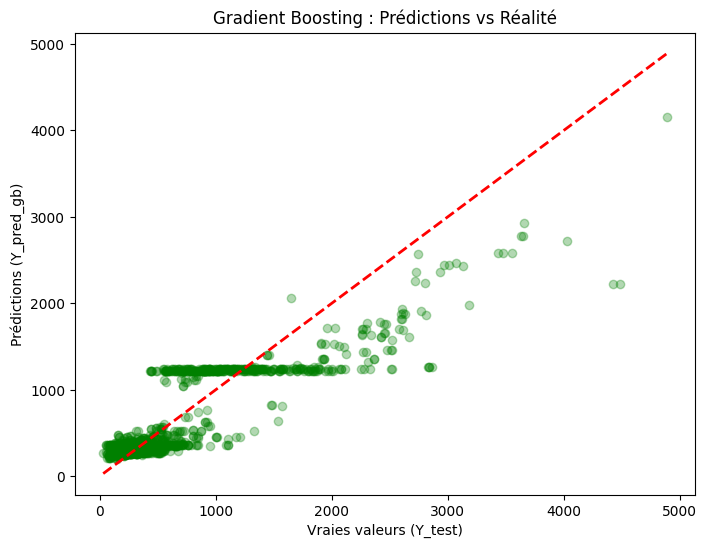

In [ ]:
# Importation nécessaire pour ce modèle
from sklearn.ensemble import GradientBoostingRegressor

# Créer le pipeline complet : 1. Prétraitement, 2. Modèle
pipeline_gb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(n_estimators=100, random_state=42))
    # n_estimators=100 est un bon point de départ, vous pouvez l'augmenter
])

# Entraîner le modèle
pipeline_gb.fit(X_train, Y_train)

# Prédire sur l'ensemble de test
Y_pred_gb = pipeline_gb.predict(X_test)

# Évaluer les performances
rmse_gb = np.sqrt(mean_squared_error(Y_test, Y_pred_gb))
r2_gb = r2_score(Y_test, Y_pred_gb)

print(f"Performance (Test Set) :")
print(f"R² (Score) : {r2_gb:.4f}")
print(f"RMSE : {rmse_gb:.4f}")

# Visualisation rapide des prédictions vs réalité
plt.figure(figsize=(8, 6))
plt.scatter(Y_test, Y_pred_gb, alpha=0.3, c='green')
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], '--', color='red', lw=2)
plt.xlabel("Vraies valeurs (Y_test)")
plt.ylabel("Prédictions (Y_pred_gb)")
plt.title("Gradient Boosting : Prédictions vs Réalité")
plt.show()

Performance (Test Set) :
R² (Score) : 0.9380
RMSE : 153.9837


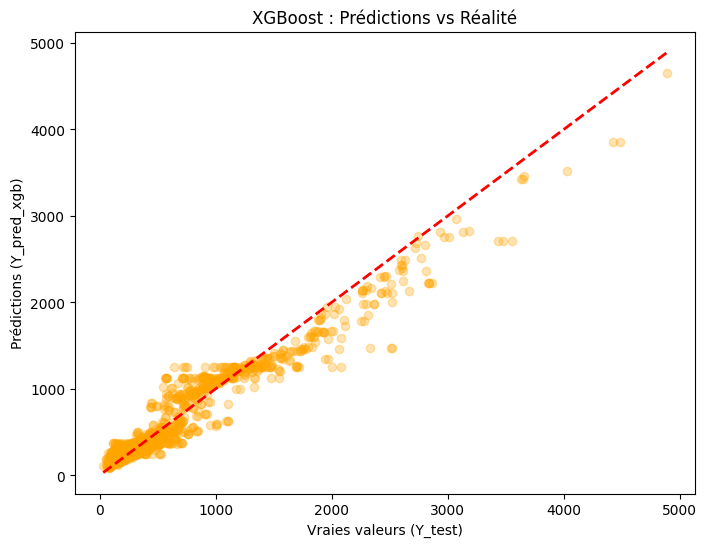

In [35]:
# Créer le pipeline complet : 1. Prétraitement, 2. Modèle
pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(n_estimators=100, random_state=42, 
                             objective='reg:squarederror'))
    # objective='reg:squarederror' est l'objectif standard pour la régression
])

# Entraîner le modèle
pipeline_xgb.fit(X_train, Y_train)

# Prédire sur l'ensemble de test
Y_pred_xgb = pipeline_xgb.predict(X_test)

# Évaluer les performances
rmse_xgb = np.sqrt(mean_squared_error(Y_test, Y_pred_xgb))
r2_xgb = r2_score(Y_test, Y_pred_xgb)

print(f"Performance (Test Set) :")
print(f"R² (Score) : {r2_xgb:.4f}")
print(f"RMSE : {rmse_xgb:.4f}")

# Visualisation rapide des prédictions vs réalité
plt.figure(figsize=(8, 6))
plt.scatter(Y_test, Y_pred_xgb, alpha=0.3, c='orange')
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], '--', color='red', lw=2)
plt.xlabel("Vraies valeurs (Y_test)")
plt.ylabel("Prédictions (Y_pred_xgb)")
plt.title("XGBoost : Prédictions vs Réalité")
plt.show()

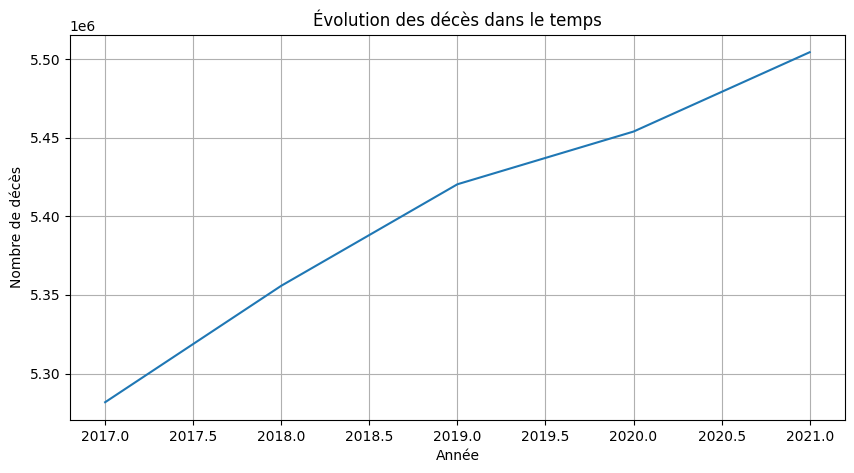

In [8]:
# Exemple : évolution des décès dans le temps
deaths = df[(df['measure'] == 'Deaths') & (df['metric'] == 'Number')]
death_by_year = deaths.groupby('year')['val'].sum().reset_index()

plt.figure(figsize=(10, 5))
sns.lineplot(data=death_by_year, x='year', y='val')
plt.title("Évolution des décès dans le temps")
plt.ylabel("Nombre de décès")
plt.xlabel("Année")
plt.grid(True)
plt.show()


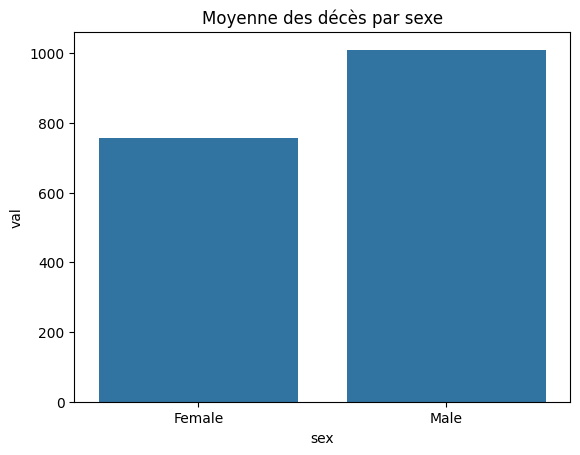

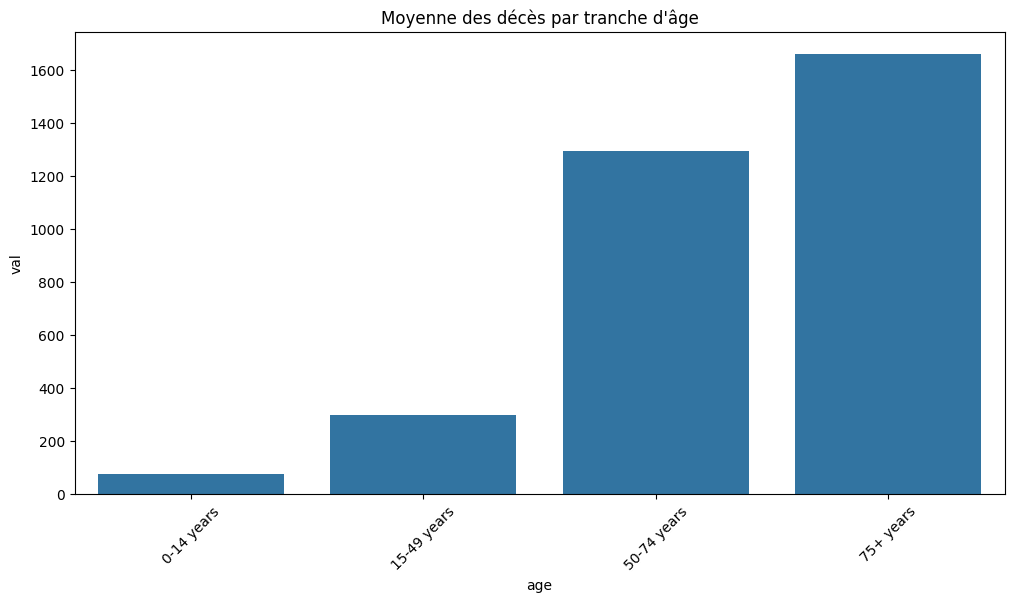

In [9]:
# Moyenne des décès par sexe
sex_grouped = deaths.groupby('sex')['val'].mean().reset_index()
sns.barplot(data=sex_grouped, x='sex', y='val')
plt.title("Moyenne des décès par sexe")
plt.show()

# Par âge
age_grouped = deaths.groupby('age')['val'].mean().reset_index()
plt.figure(figsize=(12,6))
sns.barplot(data=age_grouped, x='age', y='val')
plt.title("Moyenne des décès par tranche d'âge")
plt.xticks(rotation=45)
plt.show()


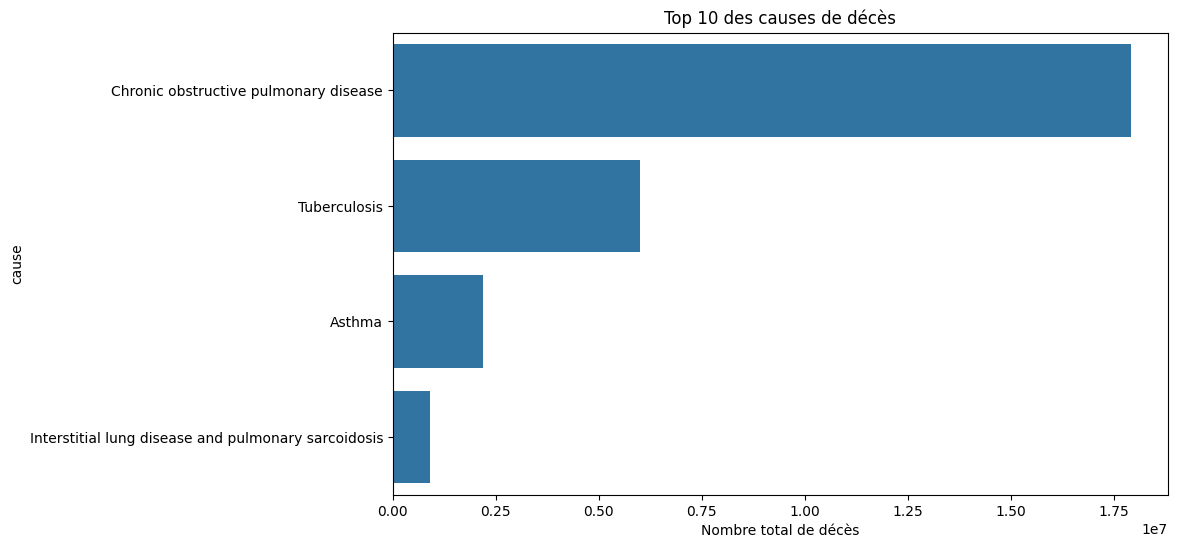

In [10]:
top_causes = deaths.groupby('cause')['val'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=top_causes.values, y=top_causes.index)
plt.title("Top 10 des causes de décès")
plt.xlabel("Nombre total de décès")
plt.show()


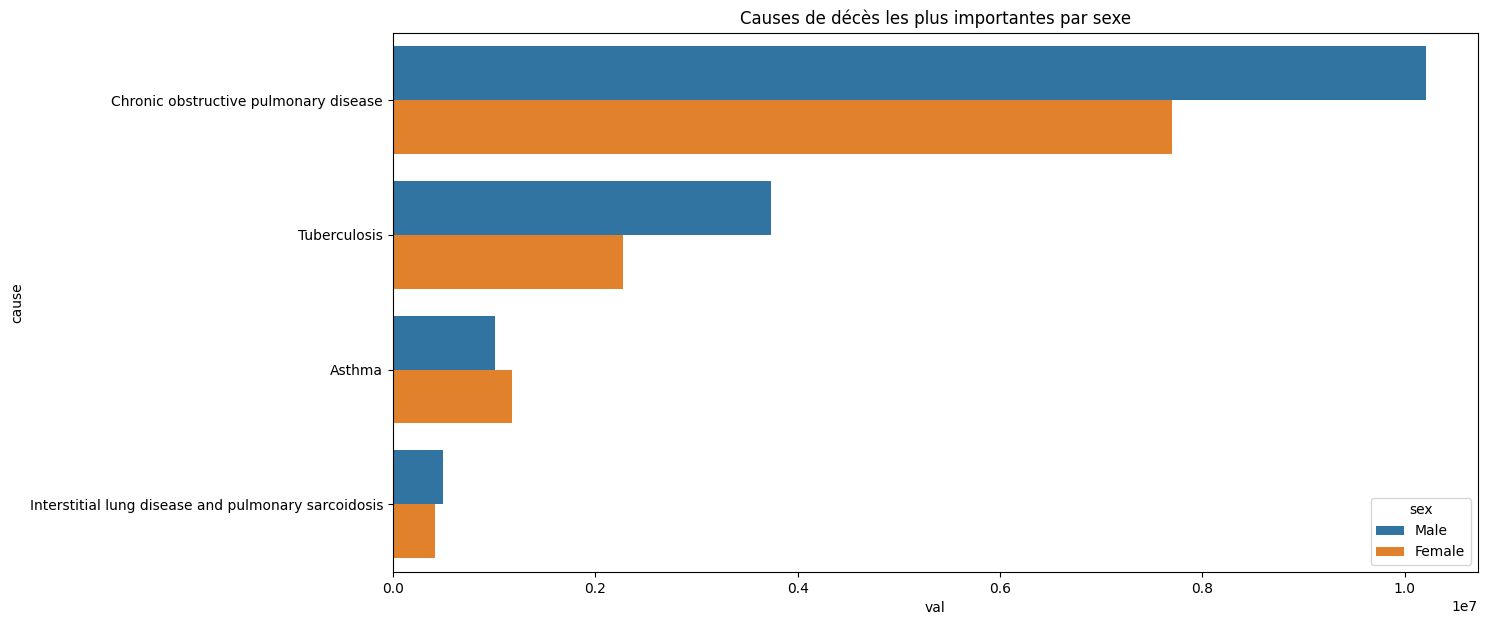

In [11]:
# Exemple : causes les plus mortelles par sexe
cause_sex = deaths.groupby(['cause', 'sex'])['val'].sum().reset_index()

plt.figure(figsize=(14, 7))
sns.barplot(data=cause_sex.sort_values(by='val', ascending=False).head(20),
            x='val', y='cause', hue='sex')
plt.title("Causes de décès les plus importantes par sexe")
plt.show()


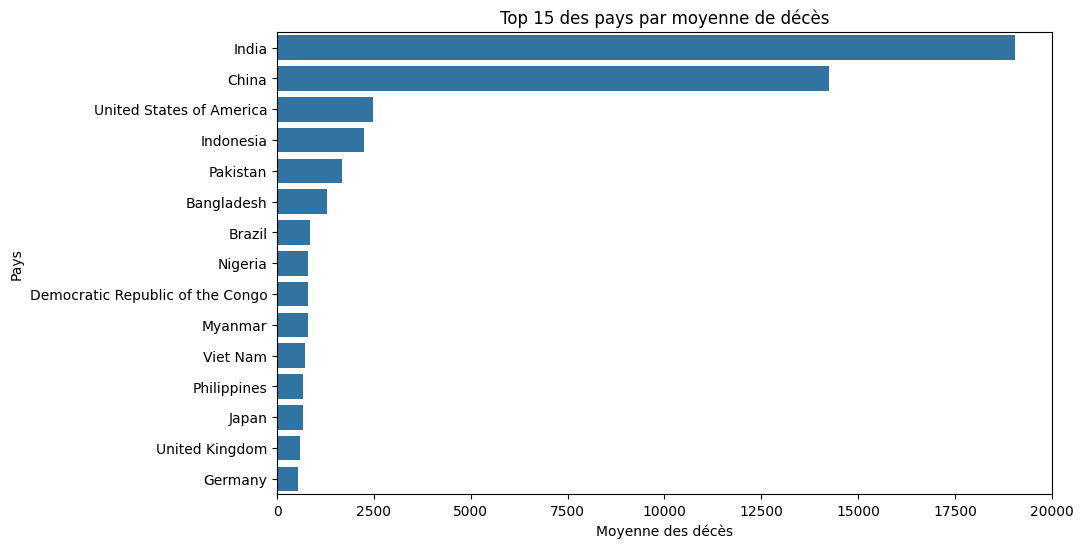

In [12]:
# Moyenne des décès par pays (top 15)
top_locations = df[df['measure'] == 'Deaths'].groupby('location')['val'].mean().sort_values(ascending=False).head(15)

plt.figure(figsize=(10,6))
sns.barplot(y=top_locations.index, x=top_locations.values)
plt.title("Top 15 des pays par moyenne de décès")
plt.xlabel("Moyenne des décès")
plt.ylabel("Pays")
plt.show()


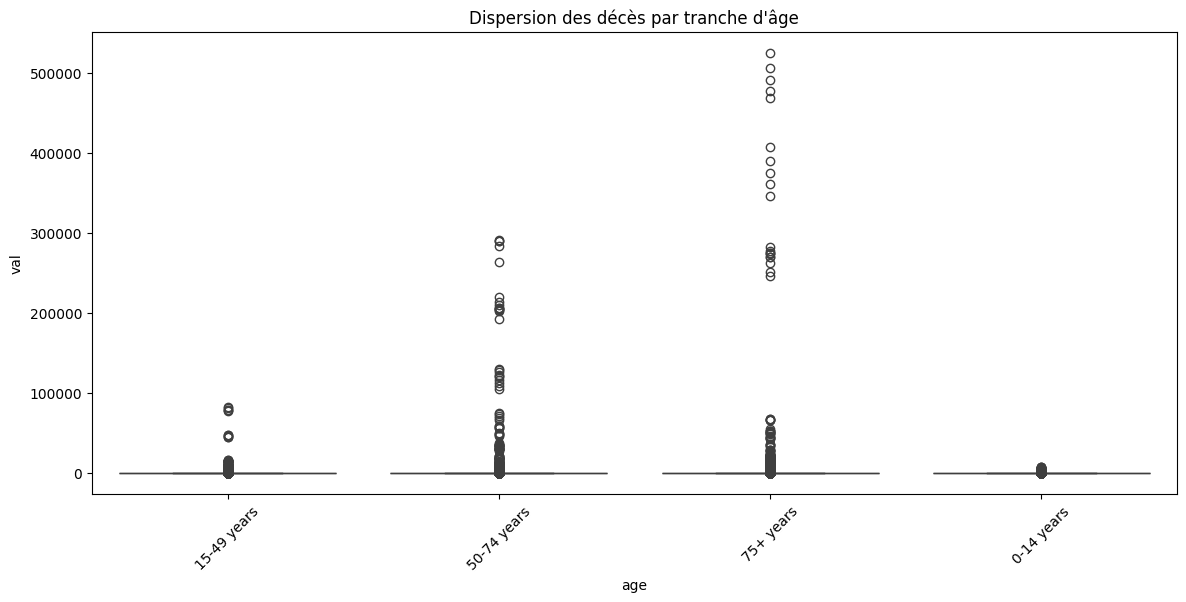

In [13]:
plt.figure(figsize=(14,6))
sns.boxplot(data=df[df['measure'] == 'Deaths'], x='age', y='val')
plt.xticks(rotation=45)
plt.title('Dispersion des décès par tranche d\'âge')
plt.show()


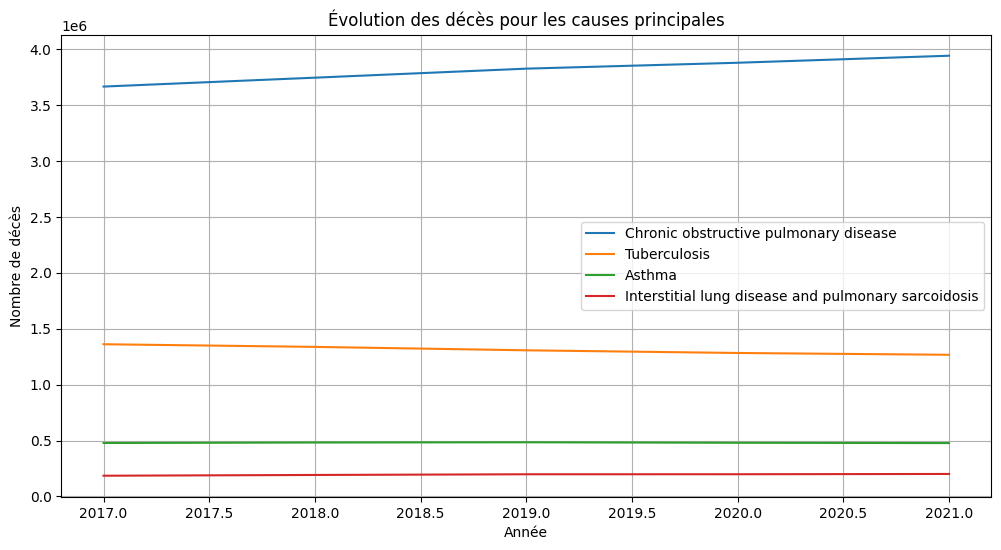

In [14]:
# Choisir quelques causes majeures
top_causes = df[df['measure'] == 'Deaths'].groupby('cause')['val'].sum().sort_values(ascending=False).head(5).index

plt.figure(figsize=(12, 6))
for cause in top_causes:
    subset = df[(df['measure'] == 'Deaths') & (df['cause'] == cause)]
    trend = subset.groupby('year')['val'].sum()
    plt.plot(trend.index, trend.values, label=cause)

plt.legend()
plt.title("Évolution des décès pour les causes principales")
plt.xlabel("Année")
plt.ylabel("Nombre de décès")
plt.grid(True)
plt.show()


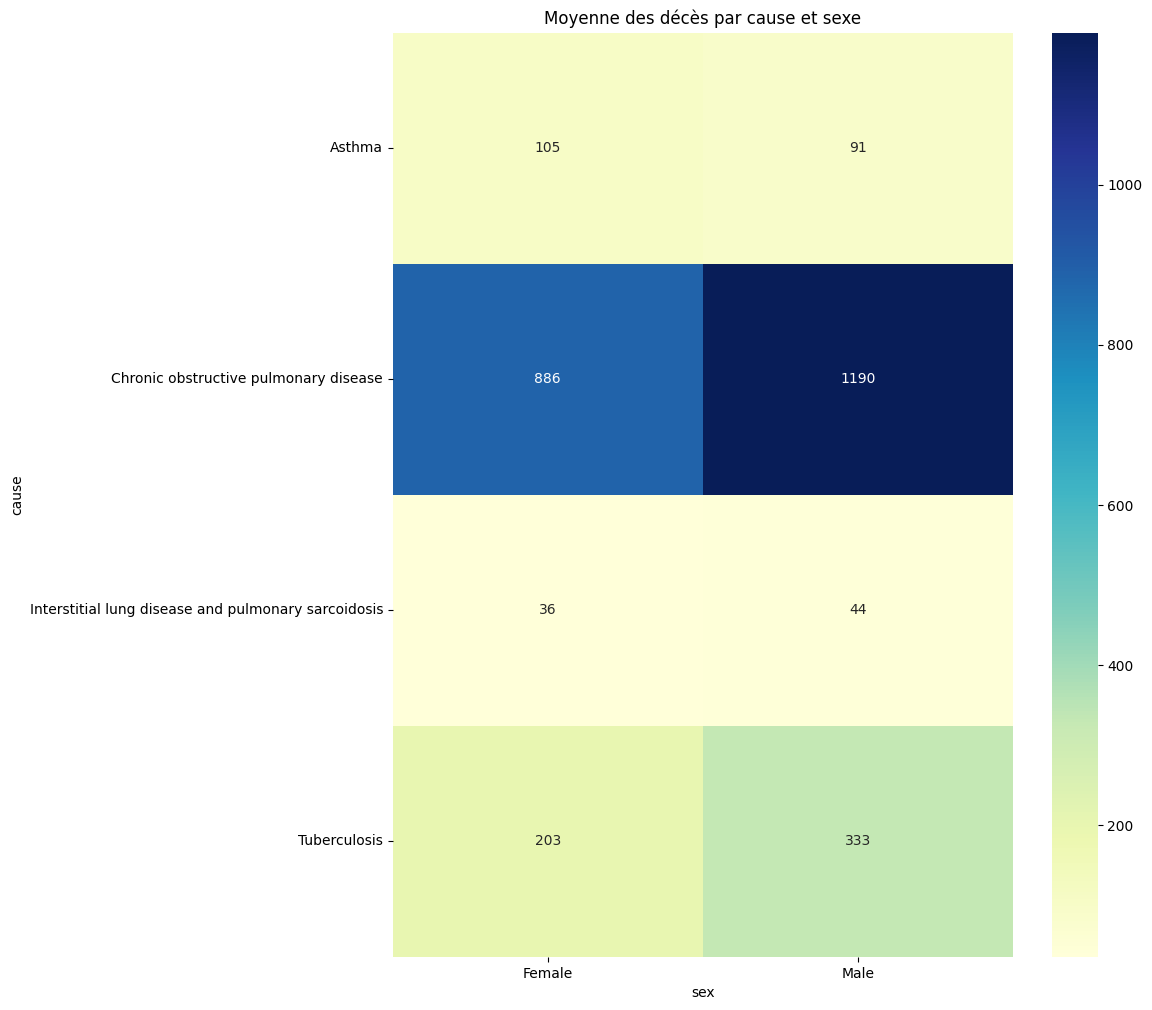

In [15]:
# Moyenne des décès par cause et sexe
pivot_sex = df[df['measure'] == 'Deaths'].pivot_table(values='val', index='cause', columns='sex', aggfunc='mean')

plt.figure(figsize=(10,12))
sns.heatmap(pivot_sex, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Moyenne des décès par cause et sexe")
plt.show()


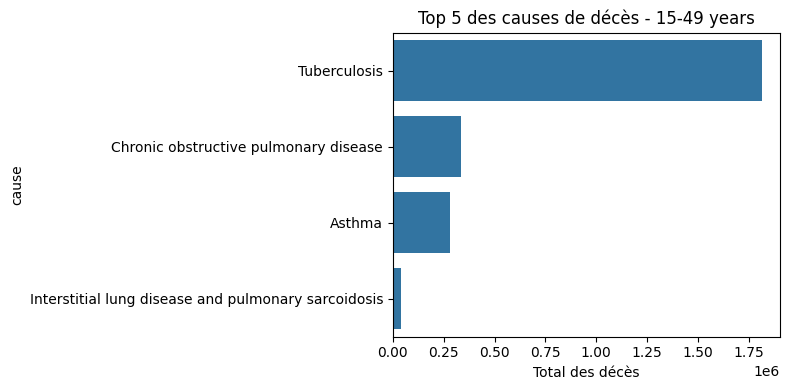

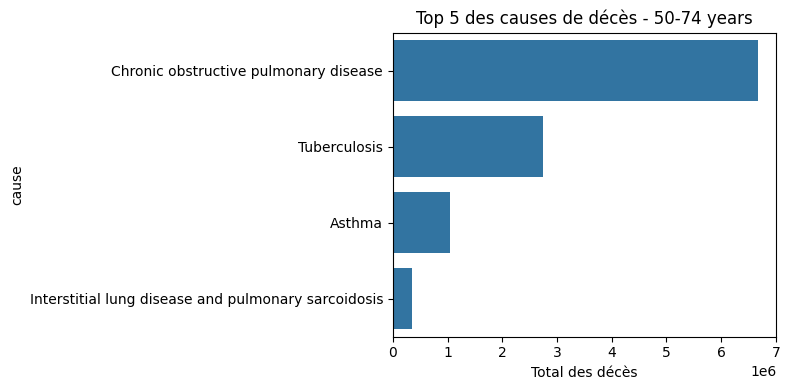

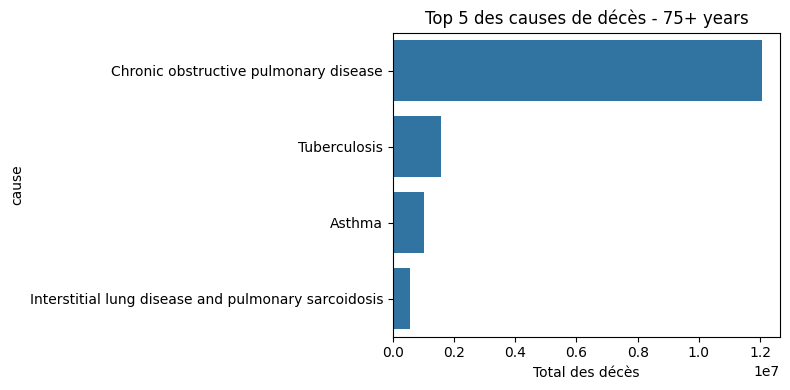

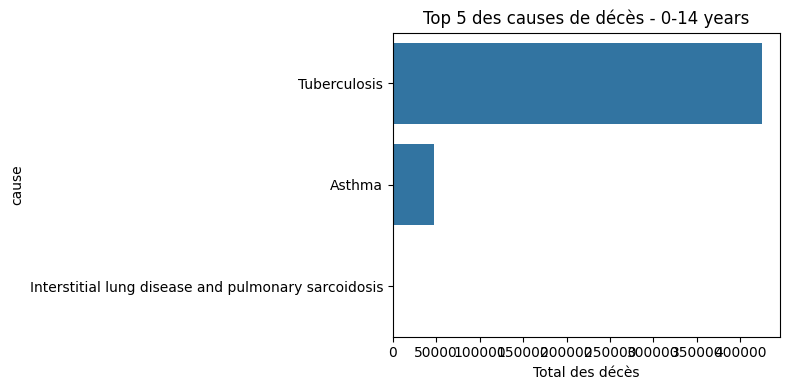

In [16]:
# Par âge : top 5 causes pour chaque tranche
age_groups = df['age'].unique()
for age_group in age_groups:
    subset = df[(df['measure'] == 'Deaths') & (df['age'] == age_group)]
    top = subset.groupby('cause')['val'].sum().sort_values(ascending=False).head(5)
    
    plt.figure(figsize=(8,4))
    sns.barplot(x=top.values, y=top.index)
    plt.title(f"Top 5 des causes de décès - {age_group}")
    plt.xlabel("Total des décès")
    plt.tight_layout()
    plt.show()


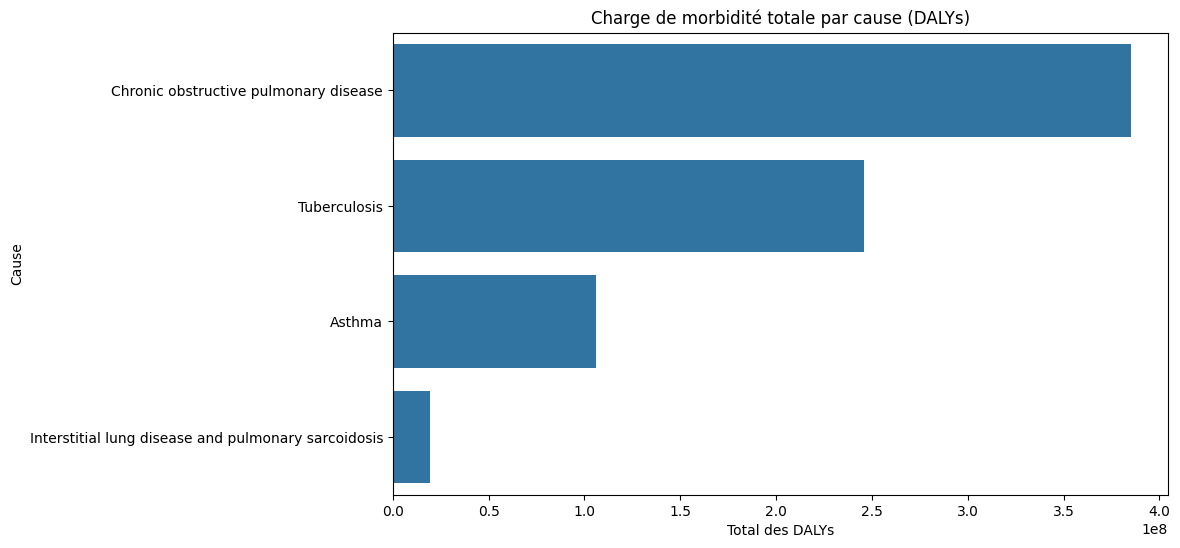

In [19]:
# Filtrer sur les DALYs et la métrique "Number"
dalys_df = df[(df['measure'] == 'DALYs (Disability-Adjusted Life Years)') & (df['metric'] == 'Number')]

# Somme des DALYs par cause
dalys_by_cause = dalys_df.groupby('cause')['val'].sum().sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=dalys_by_cause.values, y=dalys_by_cause.index)
plt.title("Charge de morbidité totale par cause (DALYs)")
plt.xlabel("Total des DALYs")
plt.ylabel("Cause")
plt.show()

In [20]:
import plotly.express as px

# Calculer le taux de prévalence moyen de l'asthme par pays
asthma_prevalence_rate = df[
    (df['measure'] == 'Prevalence') &
    (df['cause'] == 'Asthma') &
    (df['metric'] == 'Rate')
].groupby('location')['val'].mean().reset_index()

# Créer la carte
fig = px.choropleth(
    asthma_prevalence_rate,
    locations="location",
    locationmode="country names",
    color="val",
    hover_name="location",
    color_continuous_scale=px.colors.sequential.Plasma,
    title="Taux de prévalence moyen de l'asthme dans le monde"
)
fig.show()

/var/folders/28/2dlsrphn16g4ns2q8cfthd_r0000gn/T/ipykernel_16436/2423613865.py:14: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




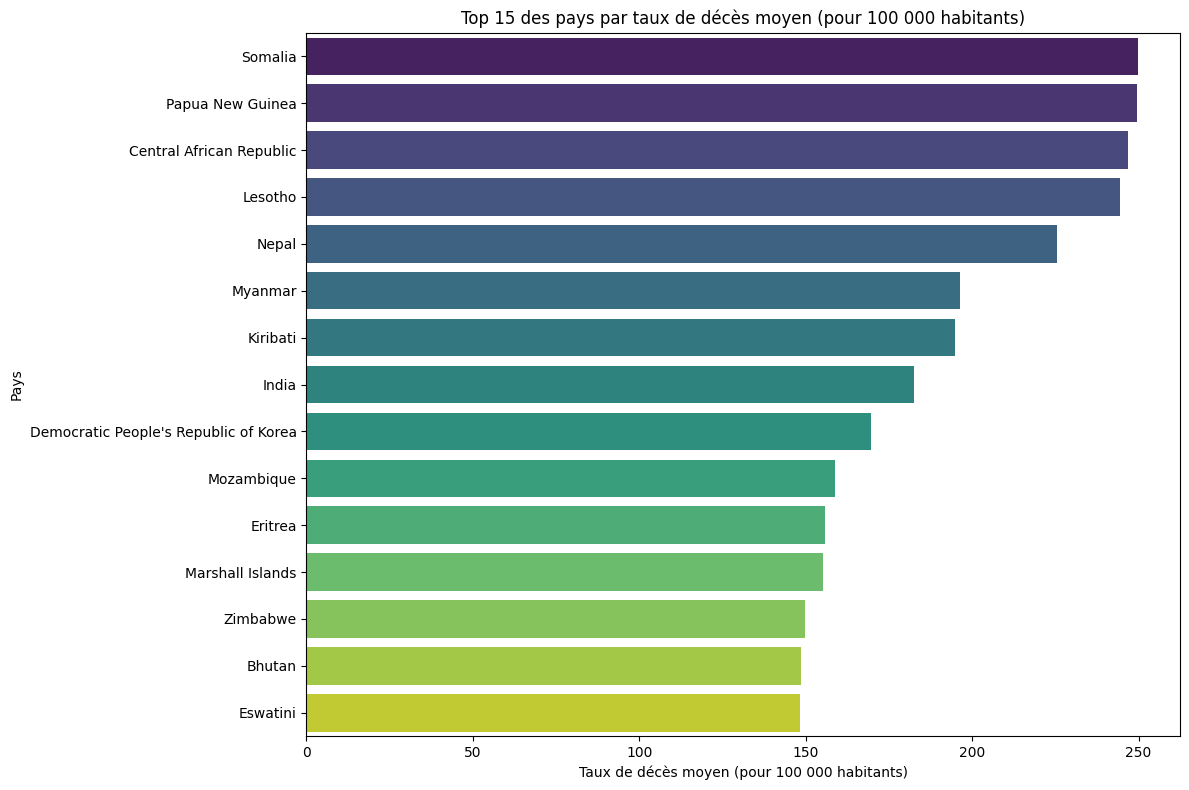

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# On filtre les données pour ne garder que les taux de mortalité.
deaths_rate = df[(df['measure'] == 'Deaths') & (df['metric'] == 'Rate')]

# On calcule le taux de décès moyen par pays et on garde les 15 plus élevés.
top_locations_rate = deaths_rate.groupby('location')['val'].mean().sort_values(ascending=False).head(15)

# Création du graphique en barres horizontales pour une meilleure lisibilité.
plt.figure(figsize=(12, 8))
sns.barplot(x=top_locations_rate.values, y=top_locations_rate.index, palette='viridis')
plt.title("Top 15 des pays par taux de décès moyen (pour 100 000 habitants)")
plt.xlabel("Taux de décès moyen (pour 100 000 habitants)")
plt.ylabel("Pays")
plt.tight_layout()
plt.show()

In [27]:
# 1. Charger le nouveau fichier CSV dans un DataFrame
pollution_filepath = 'air_quality(in).csv'
pollution_df = pd.read_csv(pollution_filepath)


/var/folders/28/2dlsrphn16g4ns2q8cfthd_r0000gn/T/ipykernel_16436/104561337.py:3: DtypeWarning:

Columns (8,10) have mixed types. Specify dtype option on import or set low_memory=False.



In [42]:
import pandas as pd
import os
import glob

# Set the path to your folder
folder_path = '/Users/mehdibenzekri/Desktop/HEIG/GML/OneDrive_1_14-10-2025'
# Parcourir tous les fichiers du dossier
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    
    # Vérifier que c’est bien un fichier (pas un dossier)
    if os.path.isfile(file_path):
        # Si le fichier n’a pas déjà l’extension .csv
        if not filename.lower().endswith(".csv"):
            new_filename = filename + ".csv"
            new_path = os.path.join(folder_path, new_filename)
            
            # Renommer le fichier
            os.rename(file_path, new_path)
            print(f"✅ {filename} → {new_filename}")


✅ tuberculosis_incidence_rate → tuberculosis_incidence_rate.csv
✅ tuberculosis_deaths_nb → tuberculosis_deaths_nb.csv
✅ tuberculosis_incidence_nb → tuberculosis_incidence_nb.csv
✅ tuberculosis_prevalence_pct → tuberculosis_prevalence_pct.csv
✅ tuberculosis_prevalence_nb → tuberculosis_prevalence_nb.csv
✅ tuberculosis_incidence_pct → tuberculosis_incidence_pct.csv
✅ tuberculosis_deaths_pct → tuberculosis_deaths_pct.csv
✅ tuberculosis_prevalence_rate → tuberculosis_prevalence_rate.csv
✅ tuberculosis_DALYs_rate → tuberculosis_DALYs_rate.csv
✅ tuberculosis_DALYs_pct → tuberculosis_DALYs_pct.csv
✅ tuberculosis_deaths_rate → tuberculosis_deaths_rate.csv


In [43]:


# Trouver tous les fichiers .csv dans ce dossier
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

# Charger tous les fichiers CSV dans une liste de DataFrames
dataframes = [pd.read_csv(f) for f in csv_files]

# Si tu veux les combiner en un seul DataFrame :
combined_df = pd.concat(dataframes, ignore_index=True)

# Vérification
print(f"{len(csv_files)} fichiers chargés.")
print(combined_df.head())

12 fichiers chargés.
  Unnamed: 0    Measure Country Name     Sex    Age Class       Disease  \
0        192  Incidence      Georgia    Male  15-49 years  Tuberculosis   
1        193  Incidence      Georgia  Female  15-49 years  Tuberculosis   
2        194  Incidence      Georgia    Male  15-49 years  Tuberculosis   
3        195  Incidence      Georgia  Female  15-49 years  Tuberculosis   
4        196  Incidence      Georgia    Male  15-49 years  Tuberculosis   

   Metric  Year        Value Country Code  ...  \
0  Number  1990  1297.824504          GEO  ...   
1  Number  1990   654.067000          GEO  ...   
2  Number  1991  1339.484340          GEO  ...   
3  Number  1991   666.735817          GEO  ...   
4  Number  1992  1372.725541          GEO  ...   

  Tobacco consumption (Cigarettes per smoker per day)  \
0                                                NaN    
1                                                NaN    
2                                                NaN    

/var/folders/28/2dlsrphn16g4ns2q8cfthd_r0000gn/T/ipykernel_16436/457527171.py:8: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



🔹 Aperçu du DataFrame :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47040 entries, 0 to 47039
Data columns (total 40 columns):
 #   Column                                                                      Non-Null Count  Dtype  
---  ------                                                                      --------------  -----  
 0   Unnamed: 0                                                                  47040 non-null  object 
 1   Measure                                                                     47040 non-null  object 
 2   Country Name                                                                47040 non-null  object 
 3   Sex                                                                         47040 non-null  object 
 4   Age Class                                                                   47040 non-null  object 
 5   Disease                                                                     47040 non-null  object 
 6   Metric                

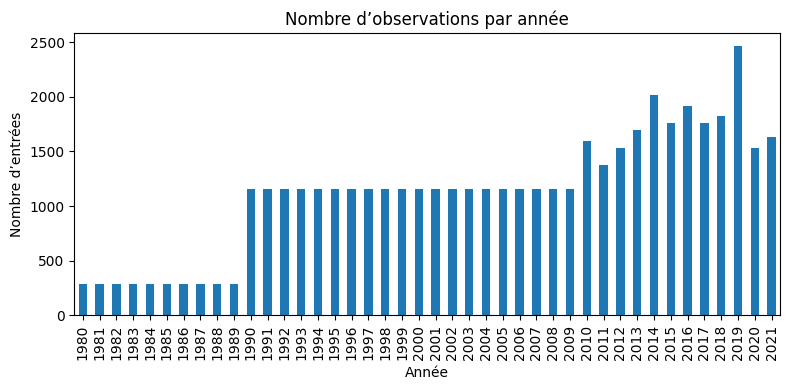


🔹 Moyenne des 'Value' par maladie :
Disease
Tuberculosis    114452.86426
Name: Value, dtype: float64


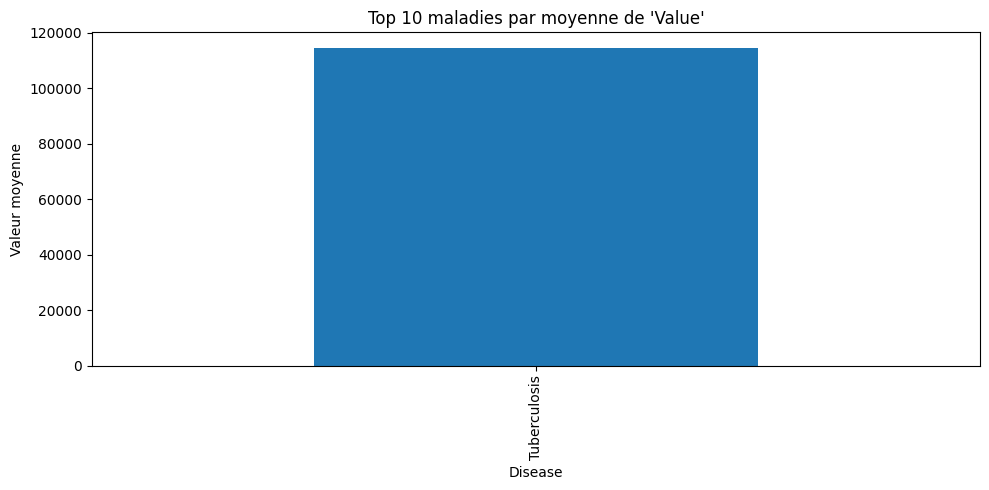


👫 Répartition par sexe :
Sex
Male      23520
Female    23520
Name: count, dtype: int64

🧒 Répartition par classe d’âge :
Age Class
15-49 years    11760
0-14 years     11760
50-74 years    11760
75+ years      11760
Name: count, dtype: int64


In [44]:
# (Tu as déjà ton DataFrame combiné)
df = combined_df.copy()

# 1️⃣ Aperçu général
print("🔹 Aperçu du DataFrame :")
print(df.info())
print("\n🔹 Aperçu des 5 premières lignes :")
print(df.head())

# 2️⃣ Vérifier les valeurs manquantes
print("\n🔹 Valeurs manquantes par colonne :")
print(df.isna().sum().sort_values(ascending=False).head(15))

# 3️⃣ Statistiques de base
print("\n🔹 Statistiques descriptives (valeurs numériques) :")
print(df.describe())

# 4️⃣ Colonnes uniques et tailles
print("\n🔹 Nombre de valeurs uniques par colonne :")
print(df.nunique().sort_values(ascending=False).head(15))

# 5️⃣ Vérifier les pays, maladies et années disponibles
print("\n🌍 Pays disponibles :", df["Country Name"].unique()[:10], "...")
print("🦠 Maladies :", df["Disease"].unique()[:10], "...")
print("📅 Années :", df["Year"].min(), "-", df["Year"].max())

# 6️⃣ Distribution des années
plt.figure(figsize=(8,4))
df["Year"].value_counts().sort_index().plot(kind="bar")
plt.title("Nombre d’observations par année")
plt.xlabel("Année")
plt.ylabel("Nombre d’entrées")
plt.tight_layout()
plt.show()

# 7️⃣ Moyenne des valeurs par maladie (si 'Value' est numérique)
if pd.api.types.is_numeric_dtype(df["Value"]):
    disease_mean = df.groupby("Disease")["Value"].mean().sort_values(ascending=False)
    print("\n🔹 Moyenne des 'Value' par maladie :")
    print(disease_mean.head(10))

    plt.figure(figsize=(10,5))
    disease_mean.head(10).plot(kind="bar")
    plt.title("Top 10 maladies par moyenne de 'Value'")
    plt.ylabel("Valeur moyenne")
    plt.tight_layout()
    plt.show()

# 8️⃣ Vérifier la cohérence des sexes et âges
print("\n👫 Répartition par sexe :")
print(df["Sex"].value_counts())

print("\n🧒 Répartition par classe d’âge :")
print(df["Age Class"].value_counts())

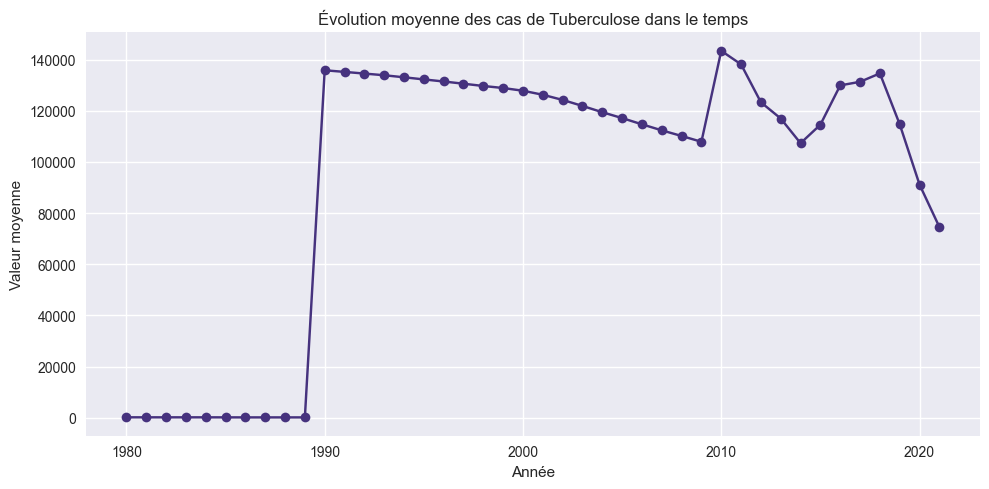

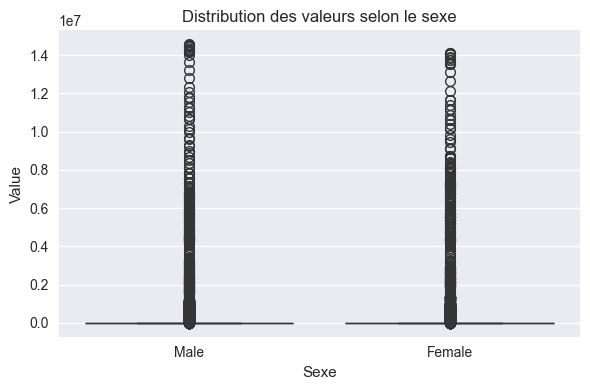

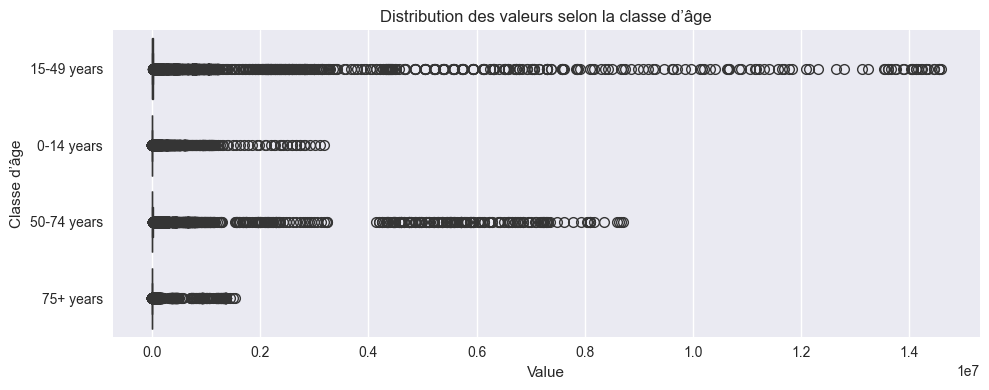

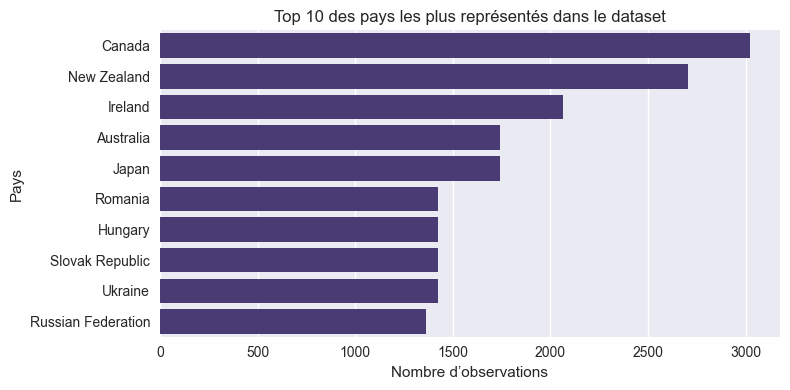

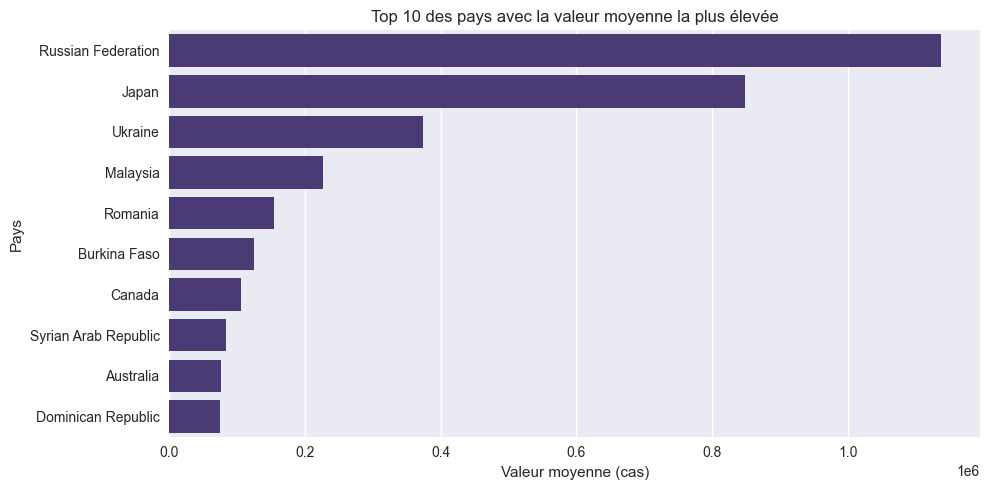

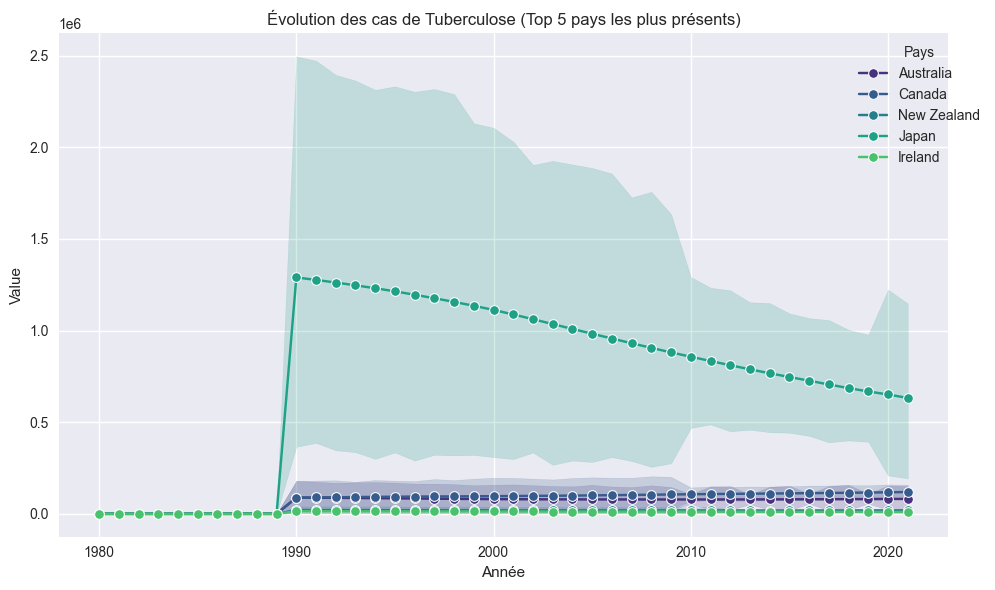

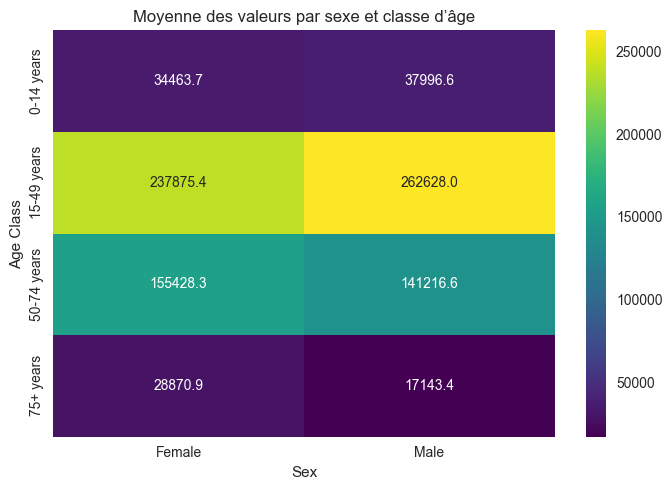

In [46]:
# 4️⃣ Évolution temporelle globale
plt.figure(figsize=(10,5))
df.groupby("Year")["Value"].mean().plot(marker="o")
plt.title("Évolution moyenne des cas de Tuberculose dans le temps")
plt.xlabel("Année")
plt.ylabel("Valeur moyenne")
plt.grid(True)
plt.tight_layout()
plt.show()

# 5️⃣ Différences par sexe
plt.figure(figsize=(6,4))
sns.boxplot(x="Sex", y="Value", data=df)
plt.title("Distribution des valeurs selon le sexe")
plt.xlabel("Sexe")
plt.ylabel("Value")
plt.tight_layout()
plt.show()

# 6️⃣ Différences par classe d’âge
plt.figure(figsize=(10,4))
sns.boxplot(y="Age Class", x="Value", data=df, orient="h")
plt.title("Distribution des valeurs selon la classe d’âge")
plt.xlabel("Value")
plt.ylabel("Classe d’âge")
plt.tight_layout()
plt.show()

# 7️⃣ Pays avec le plus grand nombre d’observations
top_countries = df["Country Name"].value_counts().head(10)
plt.figure(figsize=(8,4))
sns.barplot(x=top_countries.values, y=top_countries.index)
plt.title("Top 10 des pays les plus représentés dans le dataset")
plt.xlabel("Nombre d’observations")
plt.ylabel("Pays")
plt.tight_layout()
plt.show()

# 8️⃣ Moyenne des valeurs par pays (Top 10)
country_means = df.groupby("Country Name")["Value"].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=country_means.values, y=country_means.index)
plt.title("Top 10 des pays avec la valeur moyenne la plus élevée")
plt.xlabel("Valeur moyenne (cas)")
plt.ylabel("Pays")
plt.tight_layout()
plt.show()

# 9️⃣ Évolution temporelle pour les 5 pays principaux
top5 = df["Country Name"].value_counts().head(5).index
df_top5 = df[df["Country Name"].isin(top5)]

plt.figure(figsize=(10,6))
sns.lineplot(x="Year", y="Value", hue="Country Name", data=df_top5, marker="o")
plt.title("Évolution des cas de Tuberculose (Top 5 pays les plus présents)")
plt.xlabel("Année")
plt.ylabel("Value")
plt.legend(title="Pays", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

# 🔟 Relation âge / sexe / valeur (heatmap)
pivot = df.pivot_table(
    index="Age Class", columns="Sex", values="Value", aggfunc="mean"
)
plt.figure(figsize=(7,5))
sns.heatmap(pivot, annot=True, fmt=".1f", cmap="viridis")
plt.title("Moyenne des valeurs par sexe et classe d’âge")
plt.tight_layout()
plt.show()

🔹 Colonnes numériques disponibles : ['Year', 'Value', 'Life expectancy at birth, total (years)', 'Surface area (sq. km)', 'Total sales of agricultural pesticides (tonnes)', 'Total molluscicides (tonnes)', 'Share of population who are daily smokers (Pct population)', 'Tobacco consumption (Cigarettes per smoker per day)', 'Tobacco consumption (Grammes per person)', 'Sulphur oxides (tonnes)', 'Fine particulate matter (PM2.5) (MCR_M3)', 'Greenhouse gases (Kg CO2-equivalent Per Person)', 'Intensity of use of forest resources (Percentage Points)', 'Total area (Square Km)', 'PM10_ConcentrationAvg', 'PM25_ConcentrationAvg', 'NO2_ConcentrationAvg', 'Unnamed: 0', 'Access to clean fuels and technologies for cooking (% of population)', 'Access to electricity (% of population)', 'Carbon dioxide (CO2) emissions excluding LULUCF per capita (t CO2e/capita)', 'Compulsory education, duration (years)', 'GDP (current US$)', 'GDP per capita (constant 2015 US$)', 'Gini index', 'Mortality rate, infant (per 1

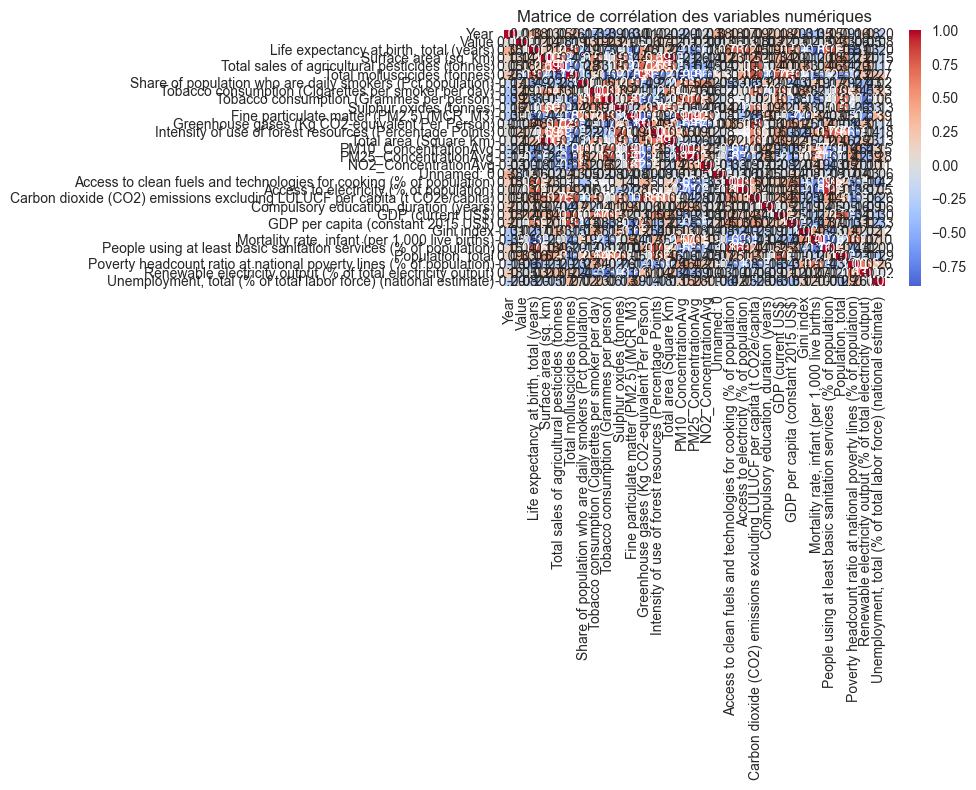


✅ Corrélations positives fortes :
Fine particulate matter (PM2.5) (MCR_M3)                                    PM25_ConcentrationAvg                                                         0.920943
PM25_ConcentrationAvg                                                       Fine particulate matter (PM2.5) (MCR_M3)                                      0.920943
PM10_ConcentrationAvg                                                       PM25_ConcentrationAvg                                                         0.920102
PM25_ConcentrationAvg                                                       PM10_ConcentrationAvg                                                         0.920102
Access to electricity (% of population)                                     People using at least basic sanitation services (% of population)             0.919227
                                                                                                                                                      

In [47]:
# Convertir les colonnes numériques
numeric_df = df.select_dtypes(include=["number"]).copy()

# Si certaines colonnes numériques sont en string avec chiffres -> conversion
for col in df.columns:
    if df[col].dtype == object:
        try:
            numeric_df[col] = pd.to_numeric(df[col], errors="coerce")
        except:
            pass

# Supprimer les colonnes entièrement vides
numeric_df = numeric_df.dropna(axis=1, how="all")

# Vérifier ce qu'on a comme variables numériques
print("🔹 Colonnes numériques disponibles :", list(numeric_df.columns))
print("🔹 Taille du sous-ensemble numérique :", numeric_df.shape)

# 1️⃣ Calcul de la matrice de corrélation
corr_matrix = numeric_df.corr()

print("\n🔹 Matrice de corrélation (extraits) :")
print(corr_matrix.head())

# 2️⃣ Visualisation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Matrice de corrélation des variables numériques")
plt.tight_layout()
plt.show()

# 3️⃣ Identifier les corrélations fortes
corr_pairs = corr_matrix.unstack().dropna().sort_values(ascending=False)
corr_pairs = corr_pairs[corr_pairs < 0.999]  # exclure auto-corrélations

strong_pos = corr_pairs[corr_pairs > 0.6]
strong_neg = corr_pairs[corr_pairs < -0.6]

print("\n✅ Corrélations positives fortes :")
print(strong_pos)

print("\n❌ Corrélations négatives fortes :")
print(strong_neg)

# 4️⃣ Interprétation automatique (si Year ou Value présentes)
interpretation = []
if "Year" in numeric_df.columns:
    if corr_matrix.loc["Year"].abs().sort_values(ascending=False).iloc[1] > 0.5:
        var = corr_matrix.loc["Year"].abs().sort_values(ascending=False).index[1]
        interpretation.append(f"La variable 'Year' montre une corrélation notable avec '{var}', ce qui suggère une tendance temporelle marquée.")
if "Value" in numeric_df.columns:
    top_corr = corr_matrix["Value"].drop("Value").sort_values(ascending=False)
    if not top_corr.empty:
        var = top_corr.index[0]
        val = top_corr.iloc[0]
        interpretation.append(f"La variable la plus corrélée positivement à 'Value' est '{var}' (corrélation = {val:.2f}).")
        var_neg = corr_matrix["Value"].drop("Value").sort_values().index[0]
        val_neg = corr_matrix["Value"].drop("Value").sort_values().iloc[0]
        interpretation.append(f"La variable la plus corrélée négativement à 'Value' est '{var_neg}' (corrélation = {val_neg:.2f}).")

print("\n🧠 Interprétation automatique :")
for sent in interpretation:
    print("•", sent)